<a href="https://colab.research.google.com/github/harsh-s15/Speech-Emotion-DL/blob/main/prasodic_cnn_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1D CNN on prasodic features**


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

In [ ]:
root = r'/content/drive/MyDrive/ser_updated/speech-emotion-recognition-ravdess-data/'

In [ ]:
import tensorflow as tf
from keras import layers, models
import os, glob, pickle

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

---
### full Dataset

In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions = emotions.values()

In [ ]:
def extractFeature(file_name, mfcc=True, chroma=True, mel=True):
    X,sample_rate = librosa.load(file_name)
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    result=np.hstack((result, mfccs))
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    return result

In [ ]:
def preprocess_data():
    x,y = [],[]
    for file in glob.glob(root + r'/Actor_*/*'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        features = extractFeature(file)
        x.append(features)
        y.append(emotion)
    return np.array(x), np.array(y)

In [ ]:
X, y = preprocess_data()

In [ ]:
# Encode labels as integers
label_map = {label: i for i, label in enumerate(np.unique(y))}
y = np.array([label_map[label] for label in y])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)

(921, 180) (921,)


In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
x_valcnn = np.expand_dims(X_val, axis=2)

In [ ]:
x_traincnn.shape

(921, 180, 1)

In [ ]:
input_shape = x_traincnn.shape[1:]
num_classes = 8
input_shape

(180, 1)

---
### model training

In [ ]:
def create_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [ ]:
model = create_model(input_shape,num_classes)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 178, 32)           128       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 89, 32)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 2848)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               364672    
                                                                 
 dense_7 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 365,832
Trainable params: 365,832
Non-trainable params: 0
________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnnhistory = model.fit(x_traincnn, y_train, batch_size=8, epochs=100, validation_data=(x_valcnn, y_val))

Epoch 1/100
116/116 [==============================] - 1s 7ms/step - loss: 2.9414 - accuracy: 0.2486 - val_loss: 2.4964 - val_accuracy: 0.2078
Epoch 2/100
116/116 [==============================] - 1s 5ms/step - loss: 2.0494 - accuracy: 0.3540 - val_loss: 2.0899 - val_accuracy: 0.3506
Epoch 3/100
116/116 [==============================] - 1s 6ms/step - loss: 1.9182 - accuracy: 0.3713 - val_loss: 2.1908 - val_accuracy: 0.3160
Epoch 4/100
116/116 [==============================] - 1s 5ms/step - loss: 1.8290 - accuracy: 0.3844 - val_loss: 1.8716 - val_accuracy: 0.3333
Epoch 5/100
116/116 [==============================] - 1s 5ms/step - loss: 1.5297 - accuracy: 0.4767 - val_loss: 1.7350 - val_accuracy: 0.3766
Epoch 6/100
116/116 [==============================] - 1s 5ms/step - loss: 1.4596 - accuracy: 0.4647 - val_loss: 1.6945 - val_accuracy: 0.3680
Epoch 7/100
116/116 [==============================] - 1s 4ms/step - loss: 1.4812 - accuracy: 0.4734 - val_loss: 1.8278 - val_accuracy: 0.3463

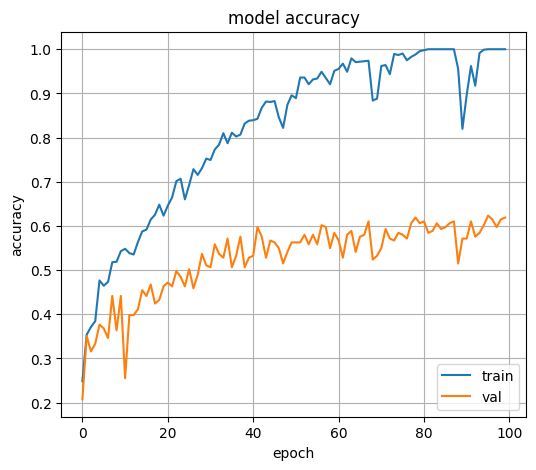

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.grid()
plt.show()

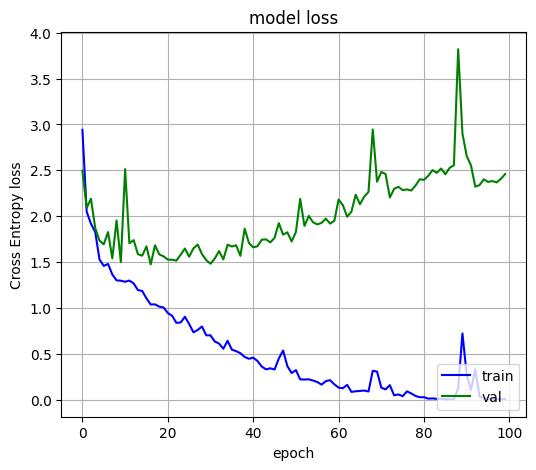

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(cnnhistory.history['loss'],'blue')
plt.plot(cnnhistory.history['val_loss'],'green')
plt.title('model loss')
plt.ylabel('Cross Entropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_testcnn, y_test)
print('Test accuracy:', test_acc)

9/9 [==============================] - 0s 3ms/step - loss: 2.6711 - accuracy: 0.5938
Test accuracy: 0.59375
